In [115]:
from scgenome import tantalus
import pandas as pd
from IPython.display import display
from scgenome import utils, cncluster, simulation, cnplot
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [72]:
all_cn_data_fp = "/Users/massoudmaher/data/SC_1936_1937_cn_data.csv"
all_cn_data = pd.read_csv(all_cn_data_fp)
all_cn_data = all_cn_data.iloc[:,1:]

In [128]:
hmmcopy_tickets = ['SC-1936', 'SC-1937']
sample_ids = [['SA921'], ['SA1090']]

# spike in params
total_ncells = 20
proportions = [0.6, 0.4]

# bhc params
n_states = 12
alpha = 0.3
prob_cn_change = 0.8
bhc_incon = 2 # inconsistent score used for making clusters from bhc
bhc_depth = 2 

# naive clusering params
naive_method = "complete"
naive_metric = "cityblock"
naive_incon = 1.1
naive_depth = 2

In [129]:
subsample = utils.get_cn_data_submixture(all_cn_data, total_ncells, hmmcopy_tickets, sample_ids, proportions=[0.6, 0.4])

mixed_cn_data = subsample["mixed_cn_data"]
cell_counts = subsample["cell_counts"]

/Users/massoudmaher/Documents/Code/scgenome/scgenome/utils.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  jira_cn_data[origin_field_name] = hmmcopy_tickets[i]


In [130]:
bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
    cncluster.bayesian_cluster(mixed_cn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change)
)

/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/massoudmaher/Documents/Code/scgenome/scgenome/cnplot.py:50: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')


[1 2 2 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1]
sample_ids [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


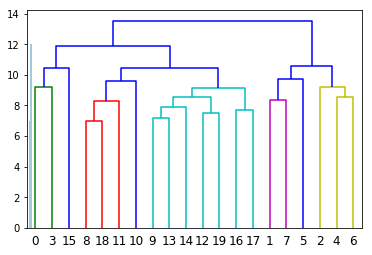

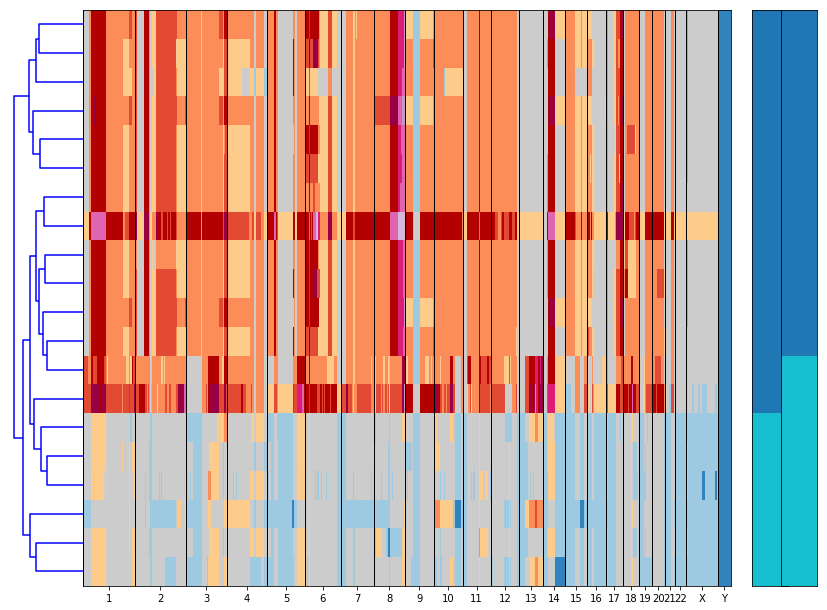

In [161]:
bhc_linkage, bhc_plot_data = simulation.get_plot_data(bhc_linkage)
bhc_plot_data[:,2] = np.log(bhc_plot_data[:,2]) # Log because the highest link is way higher

incon_scores_bhc = sch.inconsistent(bhc_plot_data)
sns.distplot(incon_scores_bhc[:,2], kde=False)

dend = sch.dendrogram(bhc_plot_data)

#bhc_clusters = sch.fcluster(bhc_plot_data, bhc_incon, depth=bhc_depth)
bhc_clusters = sch.fcluster(bhc_plot_data, 11, criterion="distance")
print(bhc_clusters)
assert len(set(bhc_clusters)) > 1
mixed_cn_data = cncluster.prune_cluster(bhc_clusters, bhc_cell_ids, mixed_cn_data)
mixed_cn_data["origin_id_int"] = mixed_cn_data["origin_id"].factorize()[0]

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, mixed_cn_data, "state", cluster_field_name="bhc_cluster_id",
    linkage=bhc_plot_data, origin_field_name="origin_id_int")

/Users/massoudmaher/Documents/Code/scgenome/scgenome/cnplot.py:50: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')


sample_ids [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


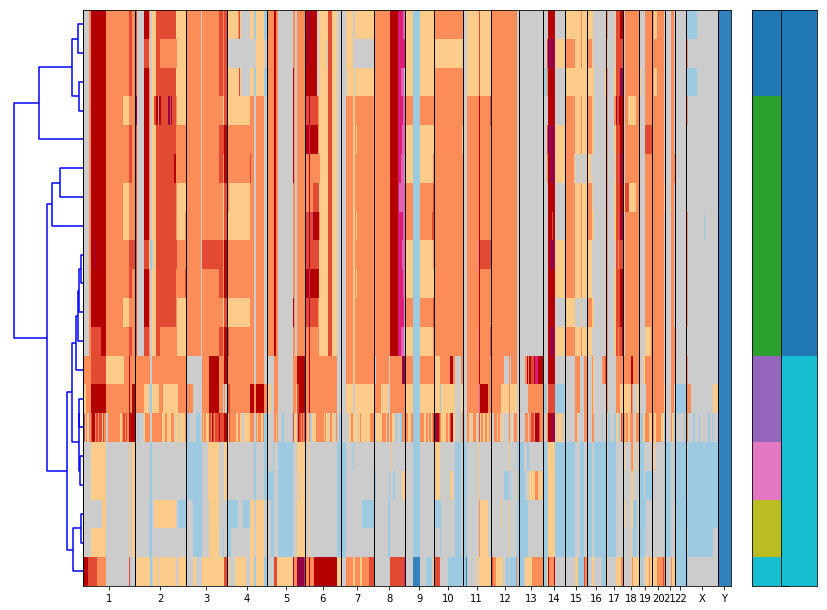

In [93]:
naive_linkage = sch.linkage(measurement, method=naive_method, metric=naive_metric)
naive_clusters = sch.fcluster(naive_linkage, naive_incon)
assert len(set(naive_clusters)) > 1
mixed_cn_data = cncluster.prune_cluster(naive_clusters, bhc_cell_ids, mixed_cn_data, 
                                        cluster_field_name="naive_cluster_id")

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, mixed_cn_data, "state", cluster_field_name="naive_cluster_id",
    linkage=naive_linkage, origin_field_name="origin_id_int")

In [101]:
umap_clusters = cncluster.umap_hdbscan_cluster(matrix_data["state"], n_neighbors=6)

In [102]:
umap_clusters

,cell_id,cluster_id,umap1,umap2
0,SA1090-A96213A-R28-C46,-1,4.612011,-12.692847
1,SA1090-A96213A-R29-C61,-1,-18.583492,13.896267
2,SA1090-A96213A-R31-C52,-1,4.211453,-12.457561
3,SA1090-A96213A-R31-C53,-1,-18.279238,13.591640
4,SA1090-A96213A-R31-C67,-1,4.327073,-12.881672
5,SA1090-A96213A-R33-C17,-1,-18.655500,13.968692
6,SA1090-A96213A-R34-C29,-1,-18.092266,13.404567
7,SA1090-A96213A-R35-C25,-1,4.648803,-12.172637
8,SA921-A90554A-R03-C22,-1,4.107573,-10.710541
9,SA921-A90554A-R03-C26,-1,2.580034,-10.891635
